# Kepler Exoplanet Detection Pipeline using Conv1D

For verification and comparison purproses, we will start by setting up a deep learning netowrk to replicate the Kepler pipeline. 

Architecture: 
Start with a stack of Dense, Linear layers
Then move onto Dense, eLU layers. 
Finally, Conv1D and eLU layers

Stage 1: initial inputs will be taken from 5000 sample light curves with 2000 injections to quickly estimate improvements in the architecture.

Stage 2: Following this, we will classify all of the injected planetary systems from NASA Exoplanet Science Institute (NExScI) https://exoplanetarchive.ipac.caltech.edu/docs/KeplerSimulated.html

Stage 3: Process all of the known threshold crossing events (transit-like features in the light curve)

Stage 4: Process a set twice as large (20k TCEs + 20k non-TCEs)

In [ ]:
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.dpi'] = 300

In [ ]:
#We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

In [ ]:
#Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

In [ ]:
from time import time
from tqdm import tqdm_notebook

## Load the data

As the data format is so simple, we do not need pandas.

In [ ]:
INPUT_LIB = '../input/'

raw_train = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_train[:, 1:]
y_train = raw_train[:, 0, np.newaxis] - 1.

raw_test = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_test[:, 1:]
y_test = raw_test[:, 0, np.newaxis] - 1.
del raw_test, raw_train

Scale each observation to zero mean and unit variance.

In [10]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

NameError: name 'x_train' is not defined

This is our only preprocessing step: We add an input corresponding to the running average over
200 time steps. This helps the net ignore high frequency noise and instead look at non-local
information. Look at the graphs below to see what it does.

In [9]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Train the model

With the Sequential API for Keras, we only need to add the layers one at a time. Each 1D convolutional layers corresponds to a local filter, and then a pooling layer reduces the data length by approximately a factor 4. At the end, there are two dense layers, just as we would in a typical image classifier. Batch normalization layers speed up convergence. 

- layer1 has 8 x 11 parameters
- layer2 16 x 8 x 11 parameter
- layer3 32 x 16 x 11 parameters

In [12]:
x_train = np.random.normal(0,1,(5000, 3197))

In [ ]:
Conv1D

In [13]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='elu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='elu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='elu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='elu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

ValueError: Input 0 is incompatible with layer conv1d_1: expected ndim=3, found ndim=2

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


The data here is extremely unbalanced, with only a few positive examples. To correct for this, I use the positive examples a lot more often, so that the net sees 50% of each over each bats. Also, I generate new examples by rotation them randomly in time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [20]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
        
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
        
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
                 
        yield x_batch, y_batch

The hyperparameters here are chosen to finish training within the Kernel, rather than to get optimal results. On a GPU, I might have chosen a smaller learning rate, and perhaps SGD instead of Adam. As it turned out, results were brilliant anyway.

In [21]:
#Start with a slightly lower learning rate, to ensure convergence
batch_size = 32

model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, batch_size), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//batch_size)

In [22]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, batch_size), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//batch_size)

Epoch 1/40
7s - loss: 0.7016 - acc: 0.5890 - val_loss: 0.6097 - val_acc: 0.6754
Epoch 2/40
6s - loss: 0.6652 - acc: 0.6329 - val_loss: 0.5700 - val_acc: 0.7035
Epoch 3/40
6s - loss: 0.6378 - acc: 0.6461 - val_loss: 0.5491 - val_acc: 0.7070
Epoch 4/40
7s - loss: 0.6519 - acc: 0.6313 - val_loss: 0.5561 - val_acc: 0.7123
Epoch 5/40
6s - loss: 0.6304 - acc: 0.6562 - val_loss: 0.5279 - val_acc: 0.7439
Epoch 6/40
6s - loss: 0.6035 - acc: 0.6768 - val_loss: 0.5377 - val_acc: 0.7368
Epoch 7/40
6s - loss: 0.6173 - acc: 0.6648 - val_loss: 0.5355 - val_acc: 0.7386
Epoch 8/40
6s - loss: 0.6123 - acc: 0.6638 - val_loss: 0.5133 - val_acc: 0.7632
Epoch 9/40
6s - loss: 0.5828 - acc: 0.6850 - val_loss: 0.5112 - val_acc: 0.7596
Epoch 10/40
5s - loss: 0.5586 - acc: 0.7216 - val_loss: 0.5207 - val_acc: 0.7596
Epoch 11/40
5s - loss: 0.5650 - acc: 0.7112 - val_loss: 0.5190 - val_acc: 0.7596
Epoch 12/40
5s - loss: 0.5686 - acc: 0.6979 - val_loss: 0.5135 - val_acc: 0.7614
Epoch 13/40
5s - loss: 0.5572 - acc: 

#Evaluate the model

First we look at convergence

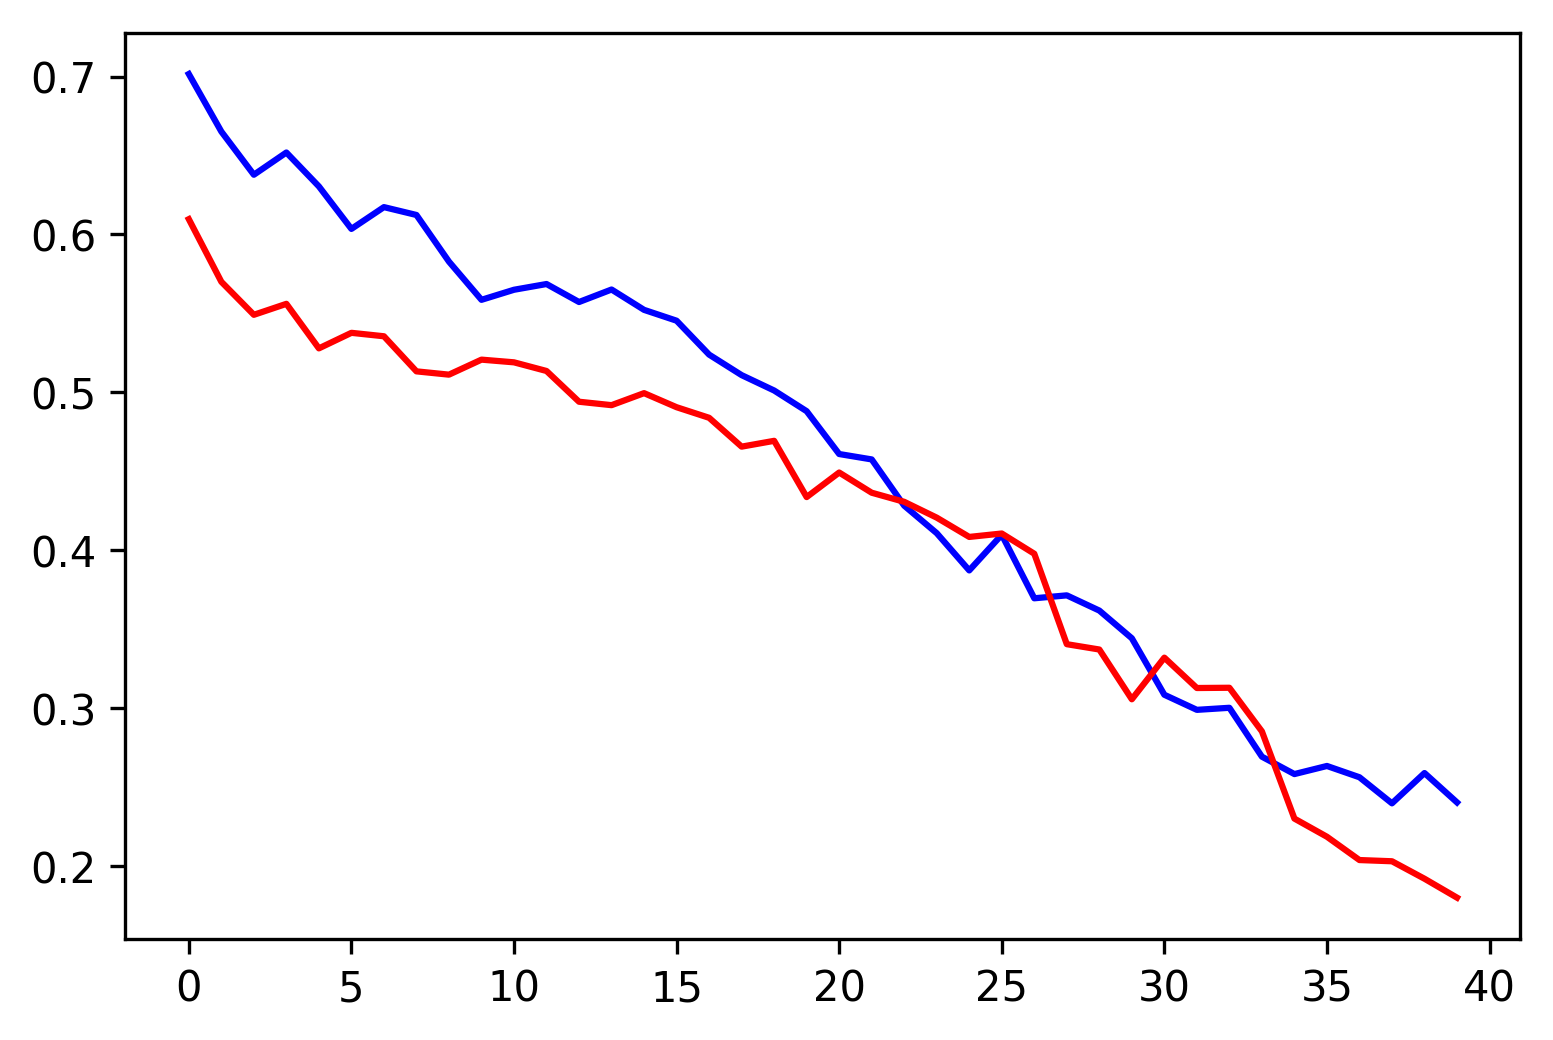

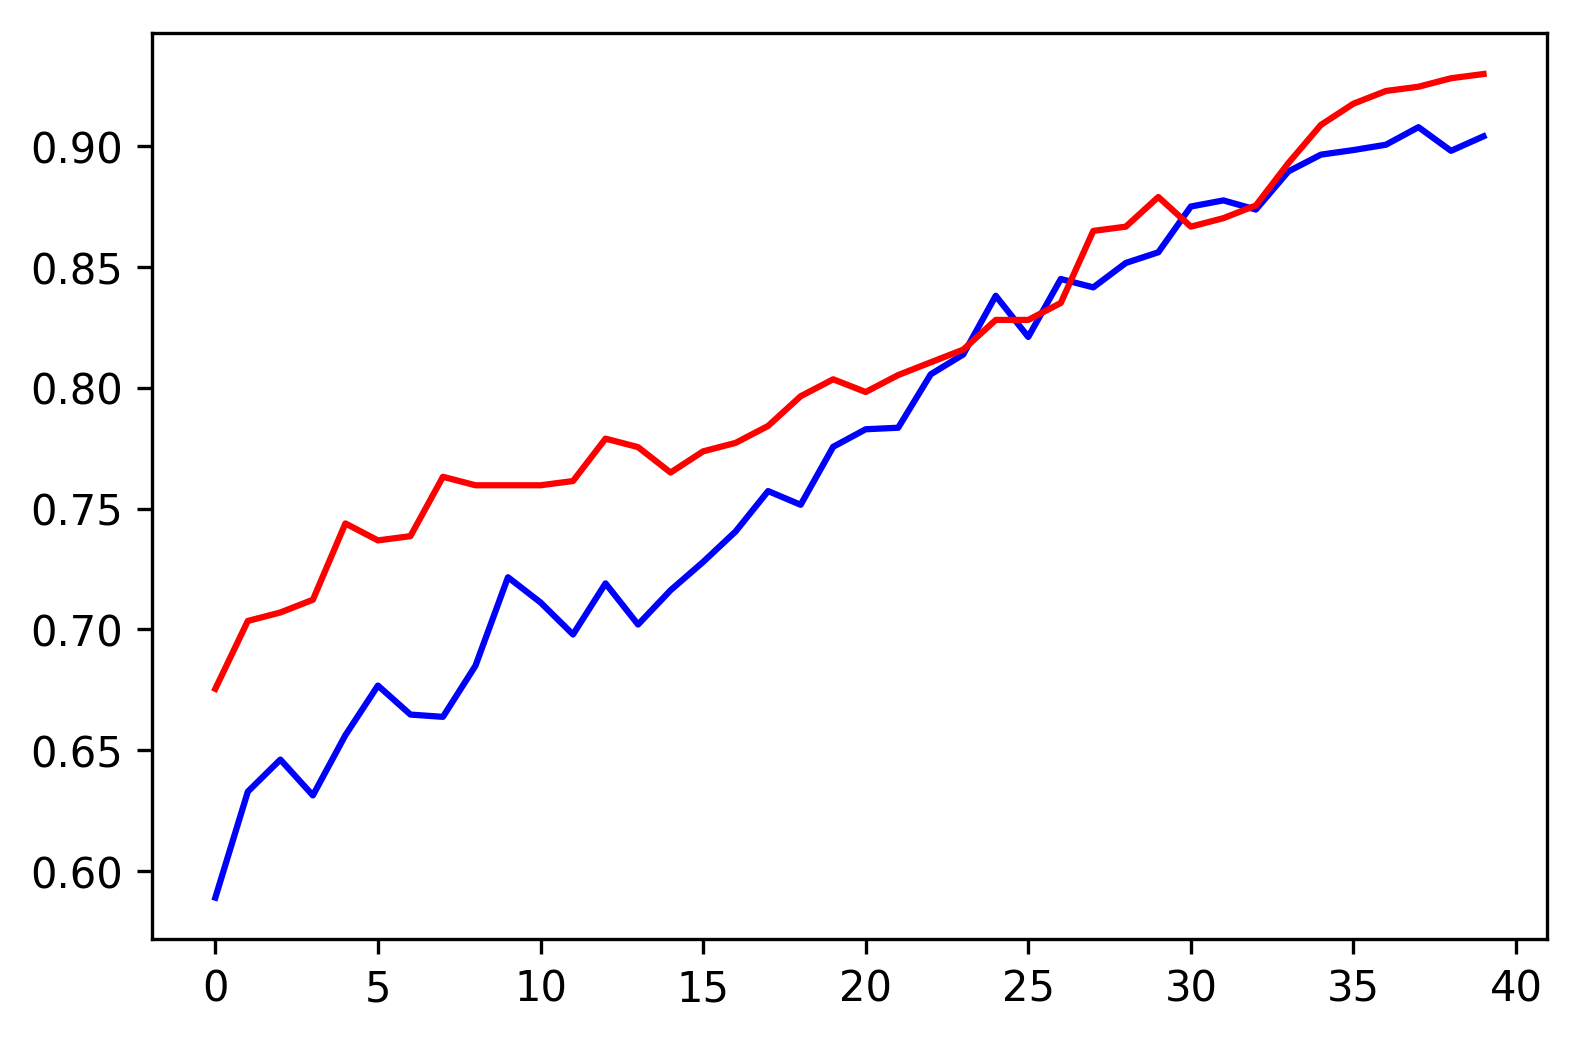

In [23]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

We then use our trained net to classify the test set.

In [24]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

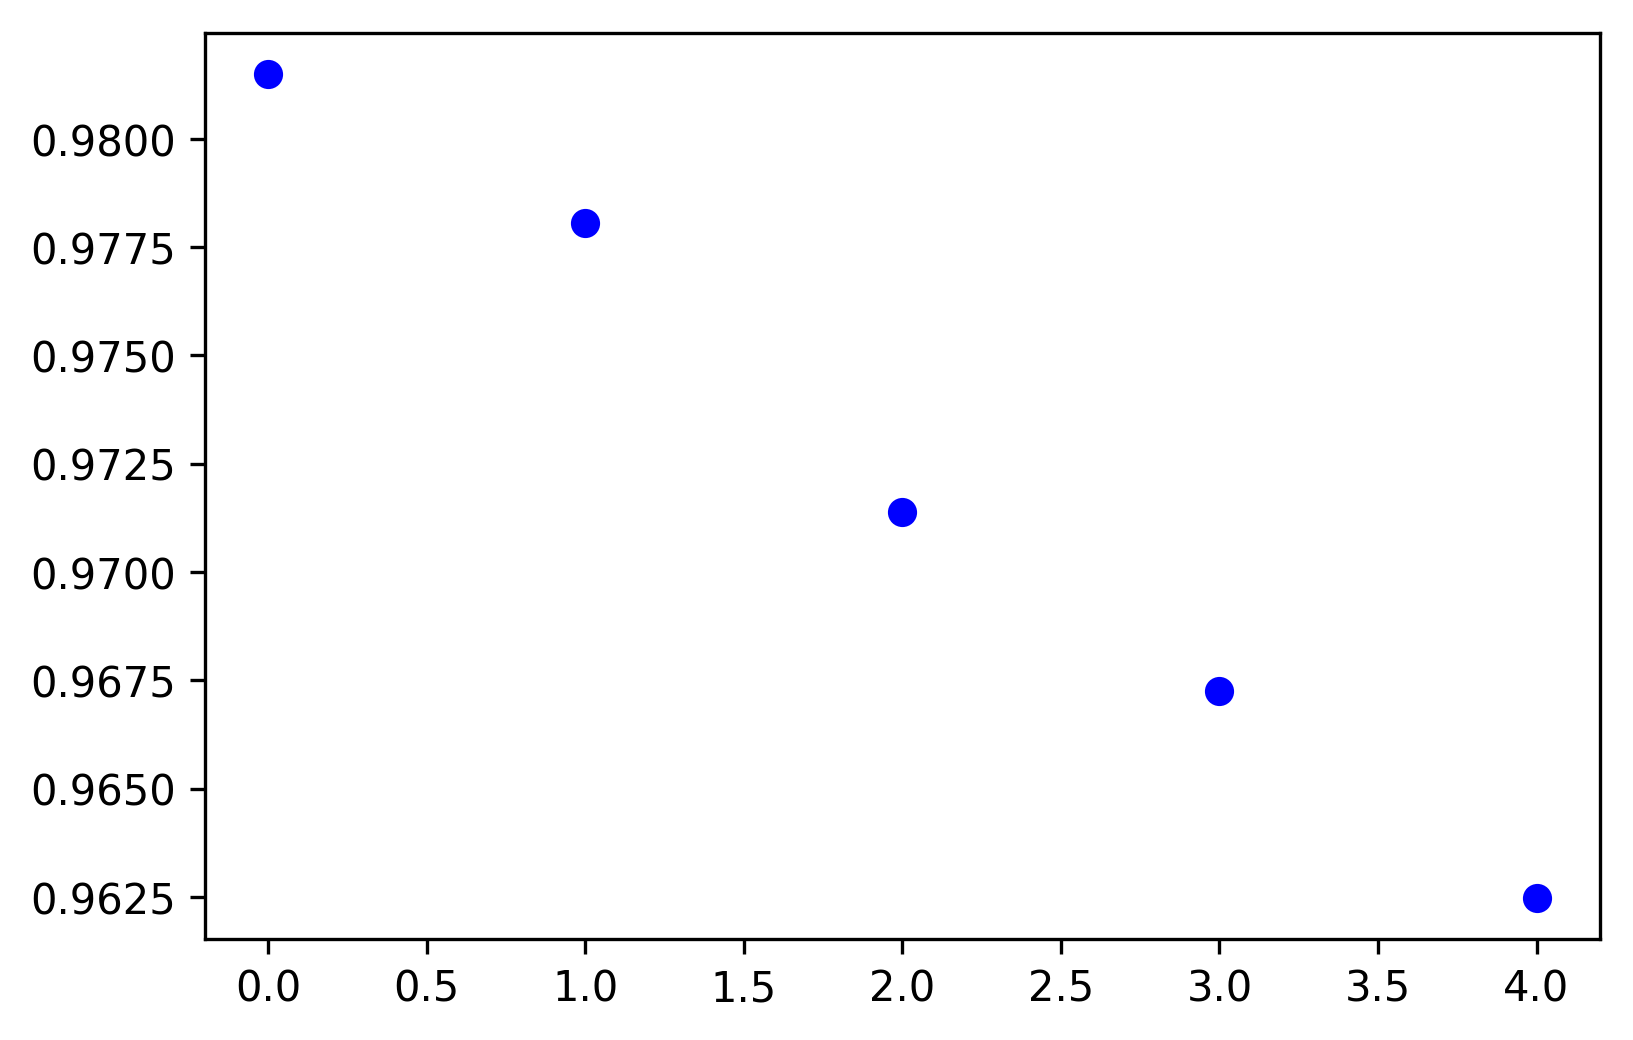

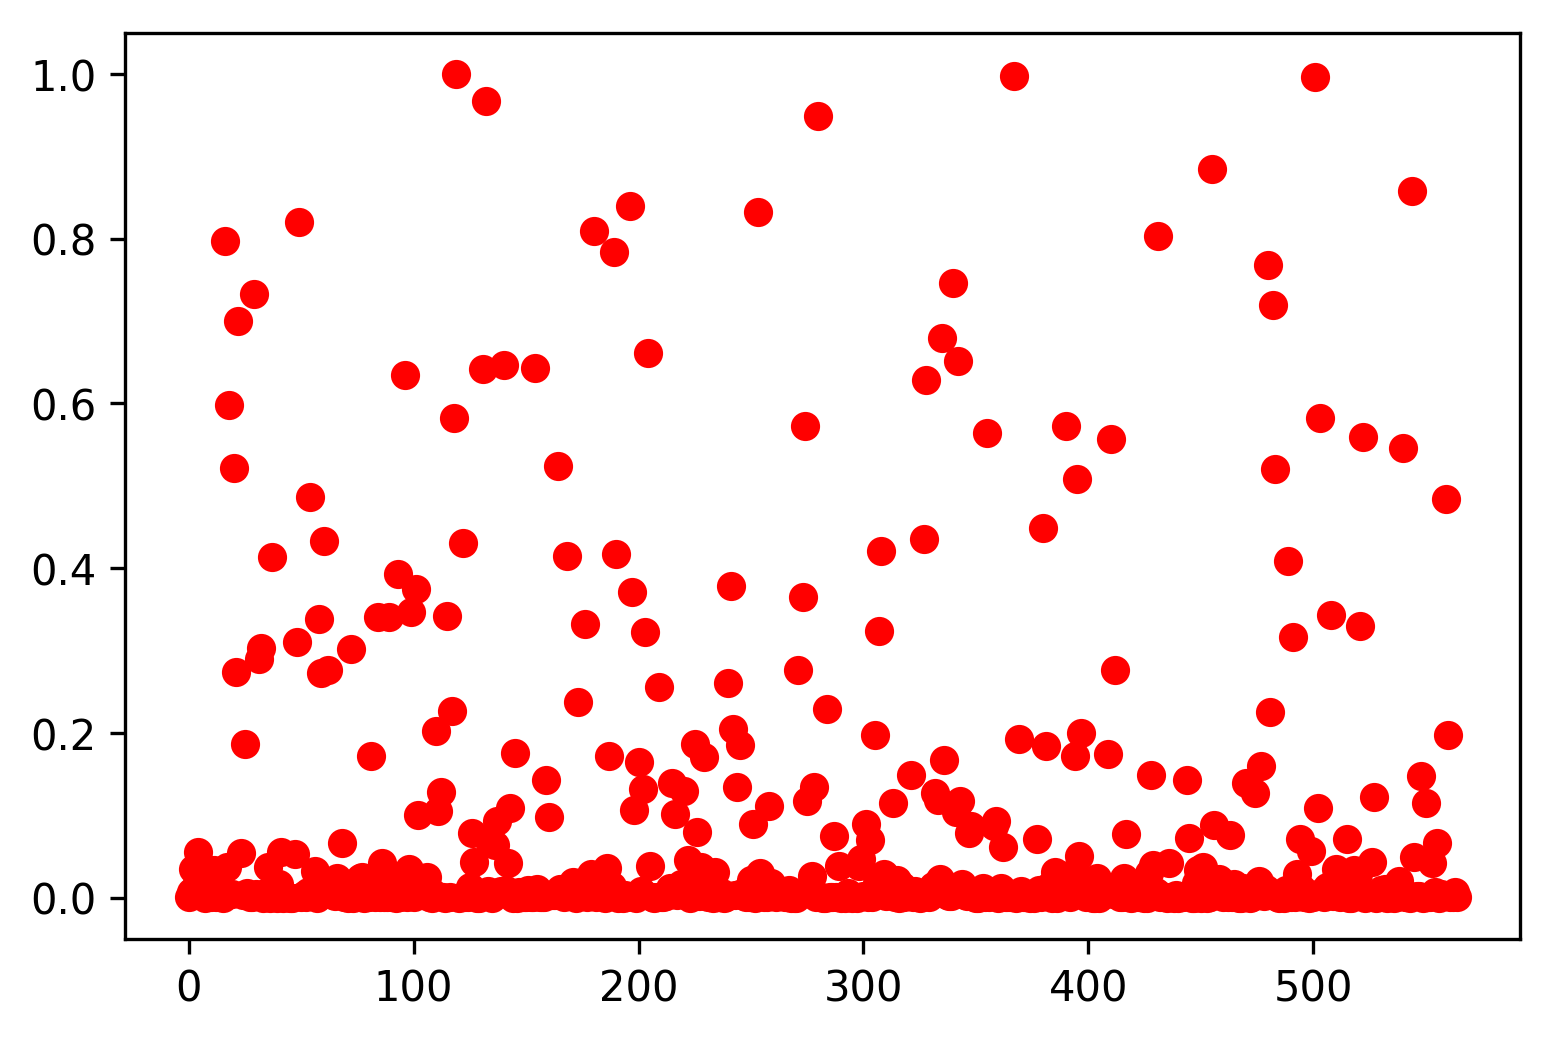

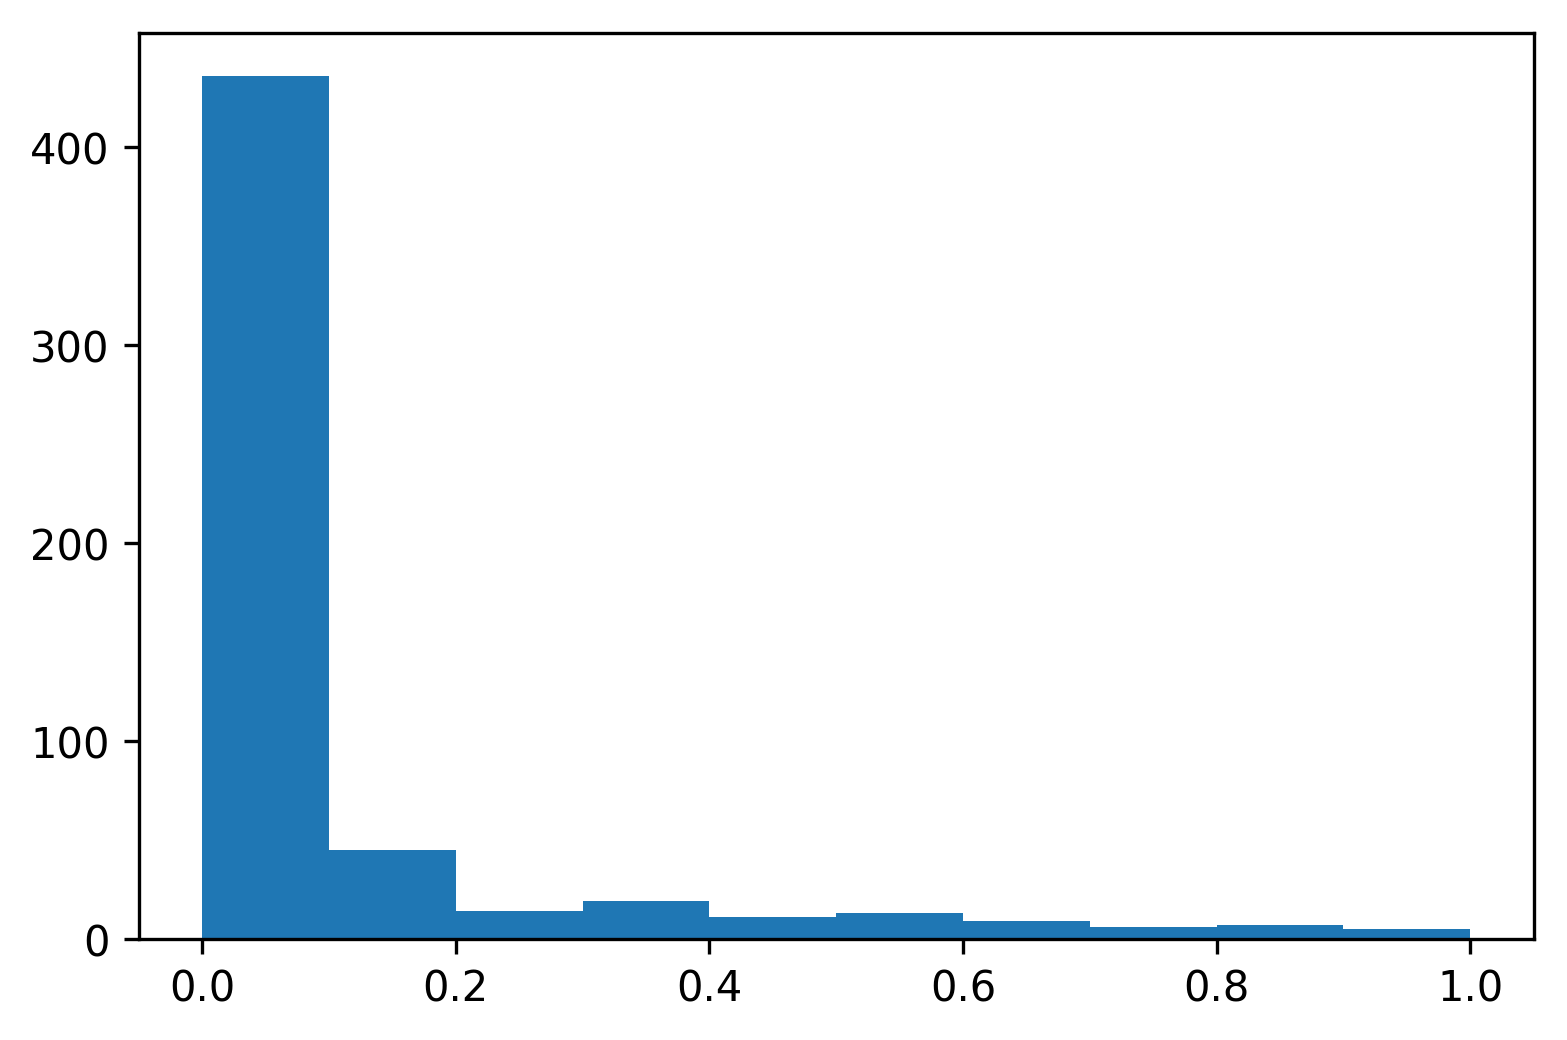

In [25]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()
plt.hist([y_hat[i] for i in non_idx])
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Also, almost all negative examples get score close to zero, except a few in the 0.9-1.0 range. This is encouraging.

We now choose an optimal cutoff score for classification. Sklearn can help us with this.

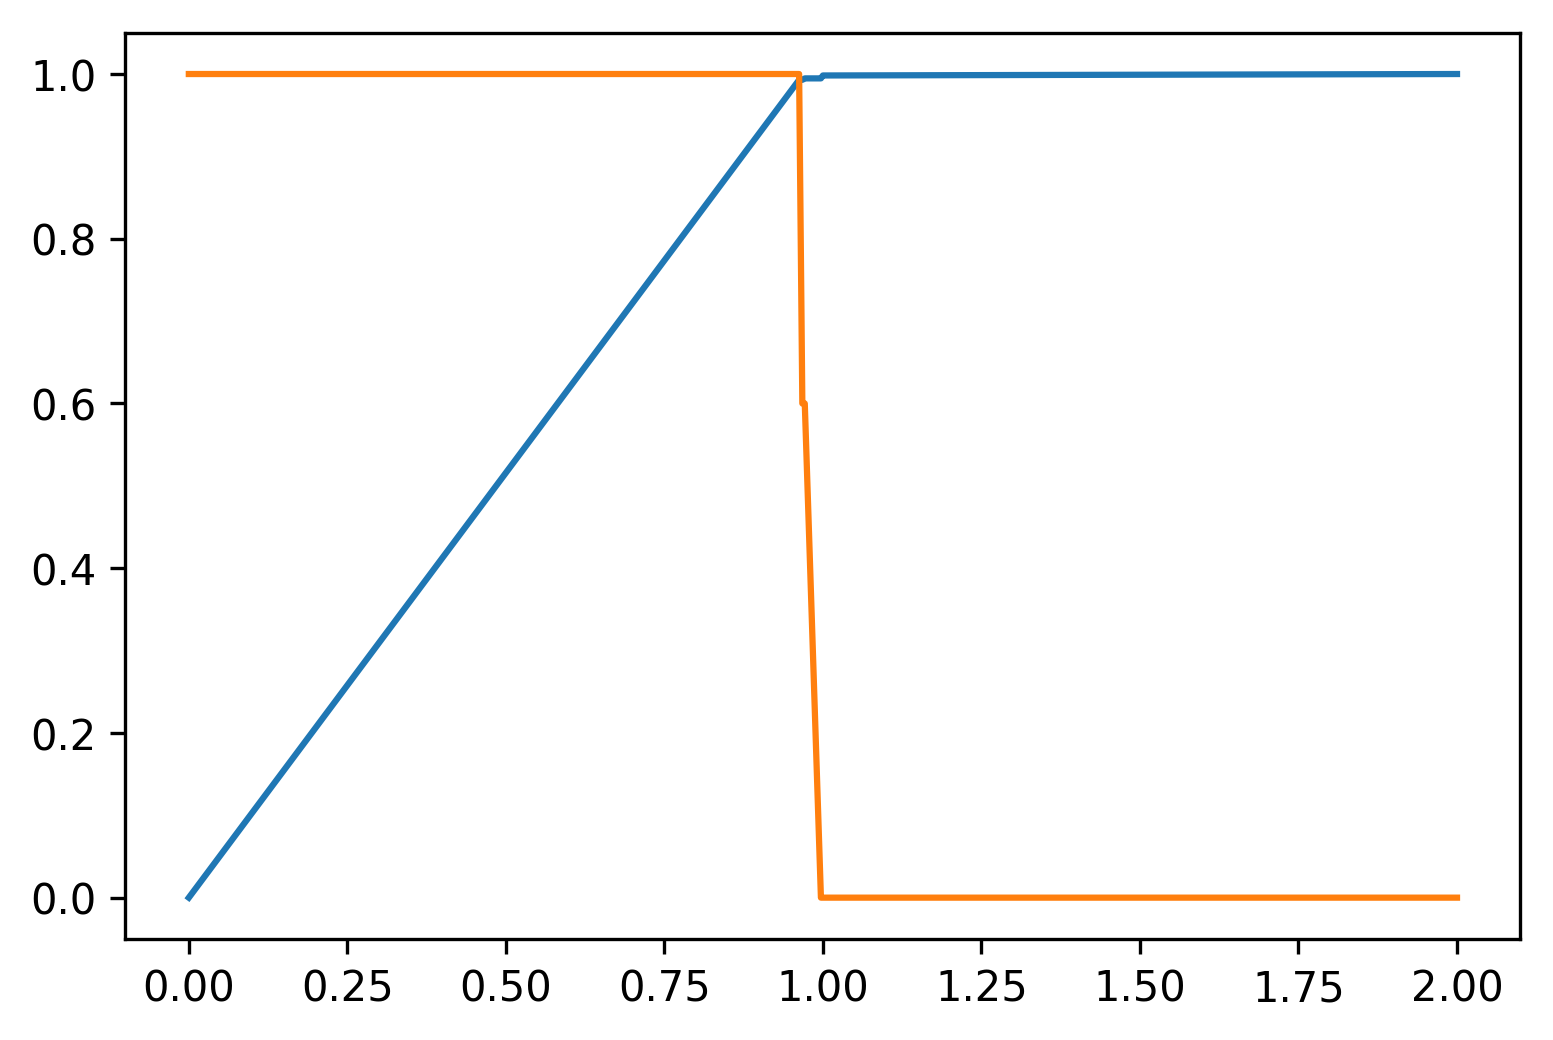

Crossover at 0.96 with specificity 0.99


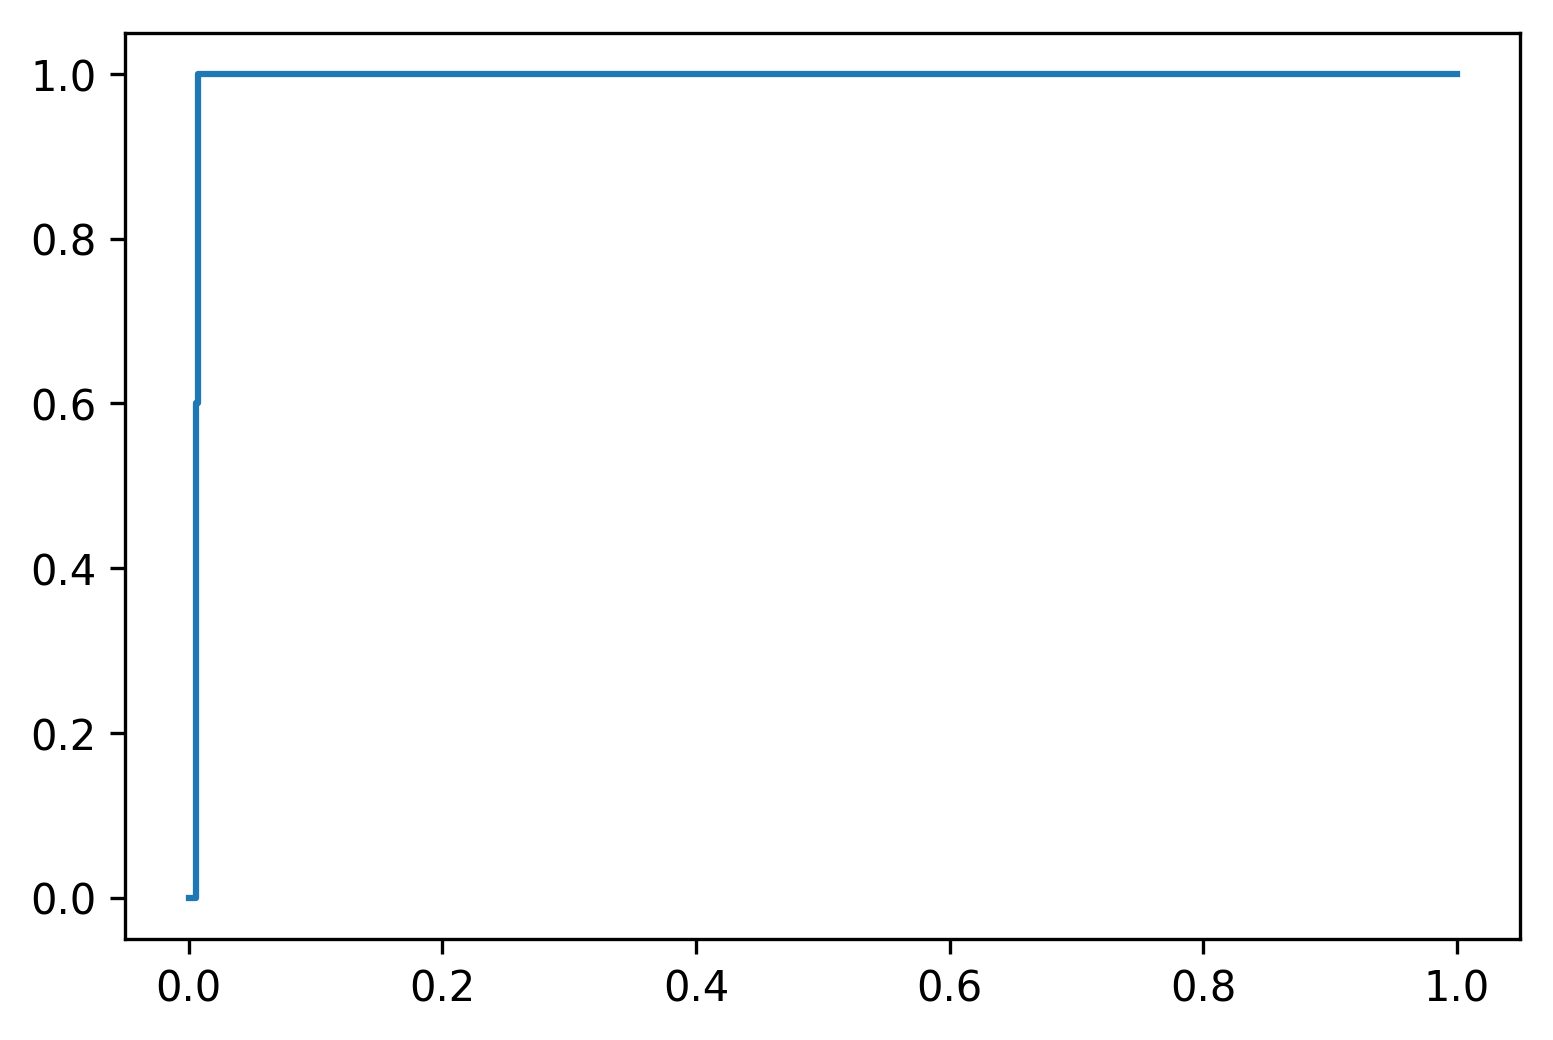

ROC area under curve is 0.99


In [26]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()

crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

Let's take a look at the misclassified data (if any):

124 0.999995 False


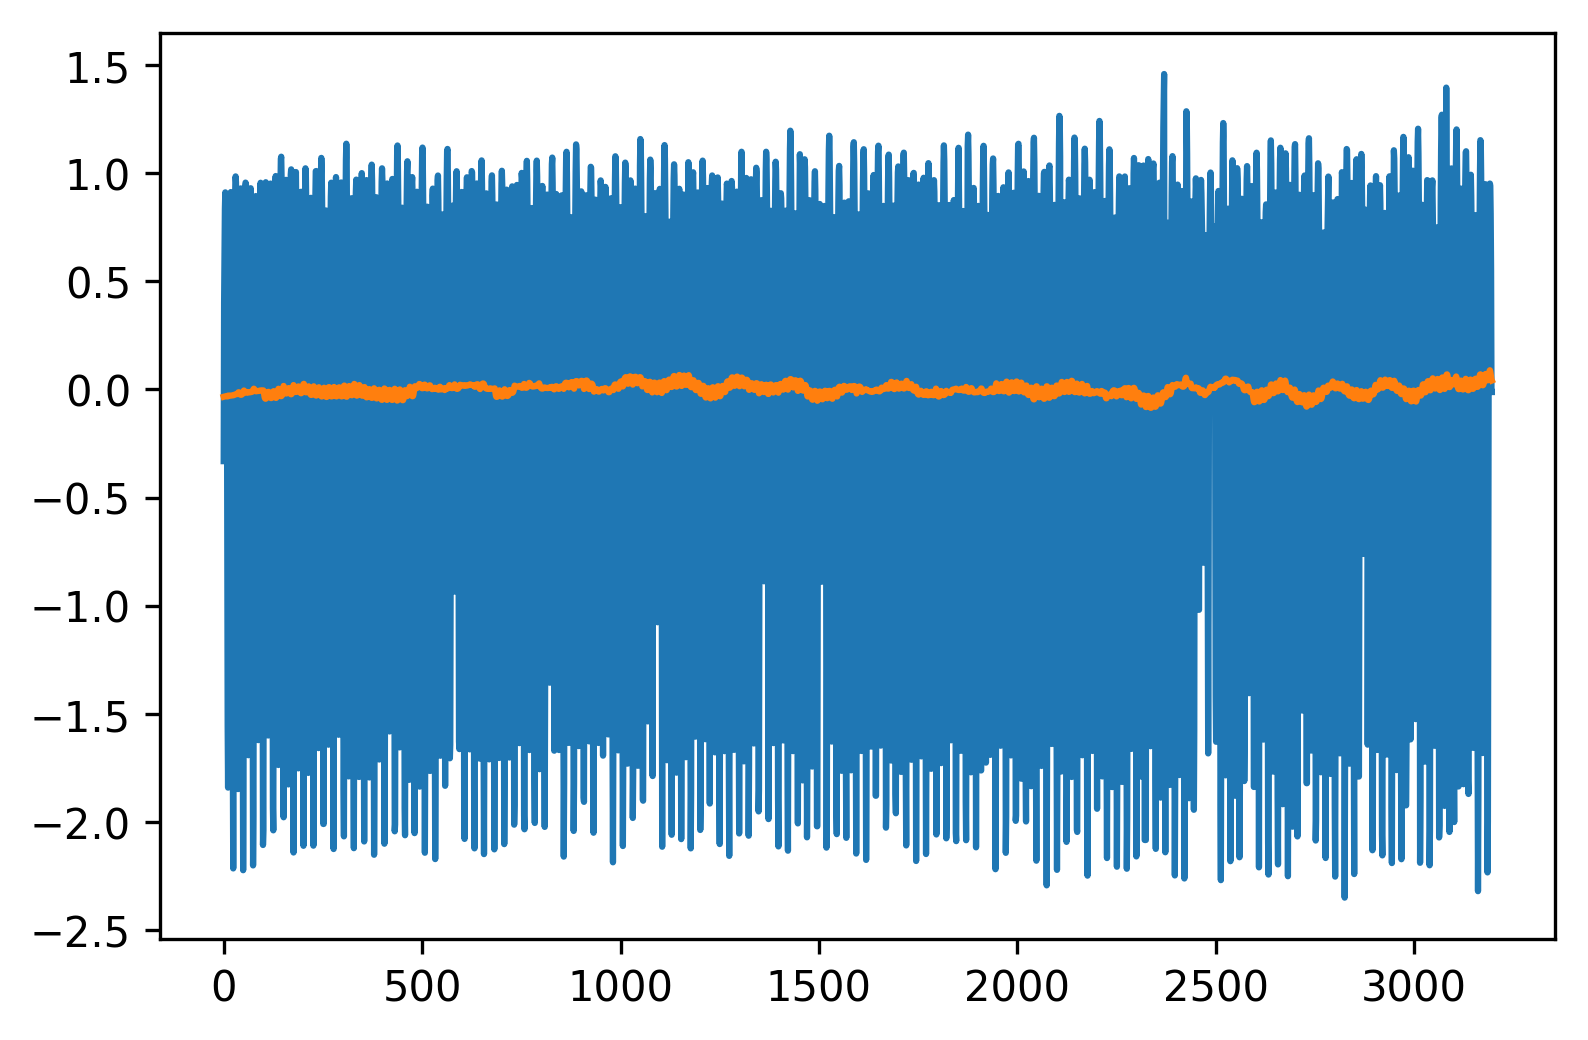

137 0.967542 False


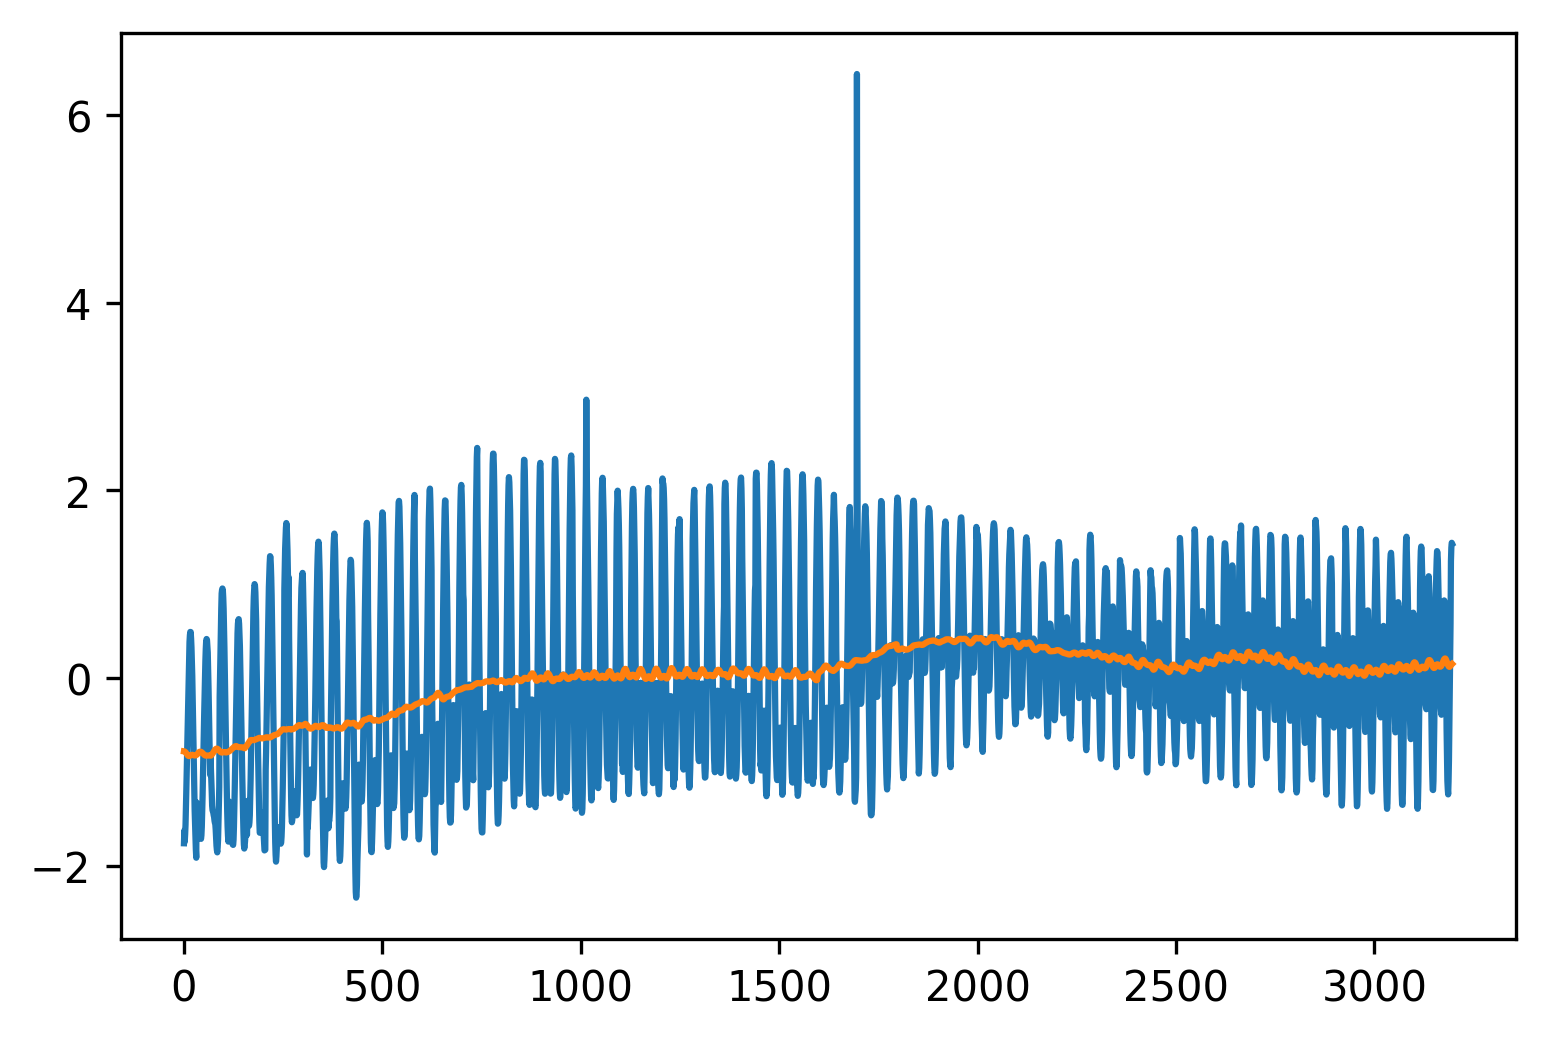

372 0.997778 False


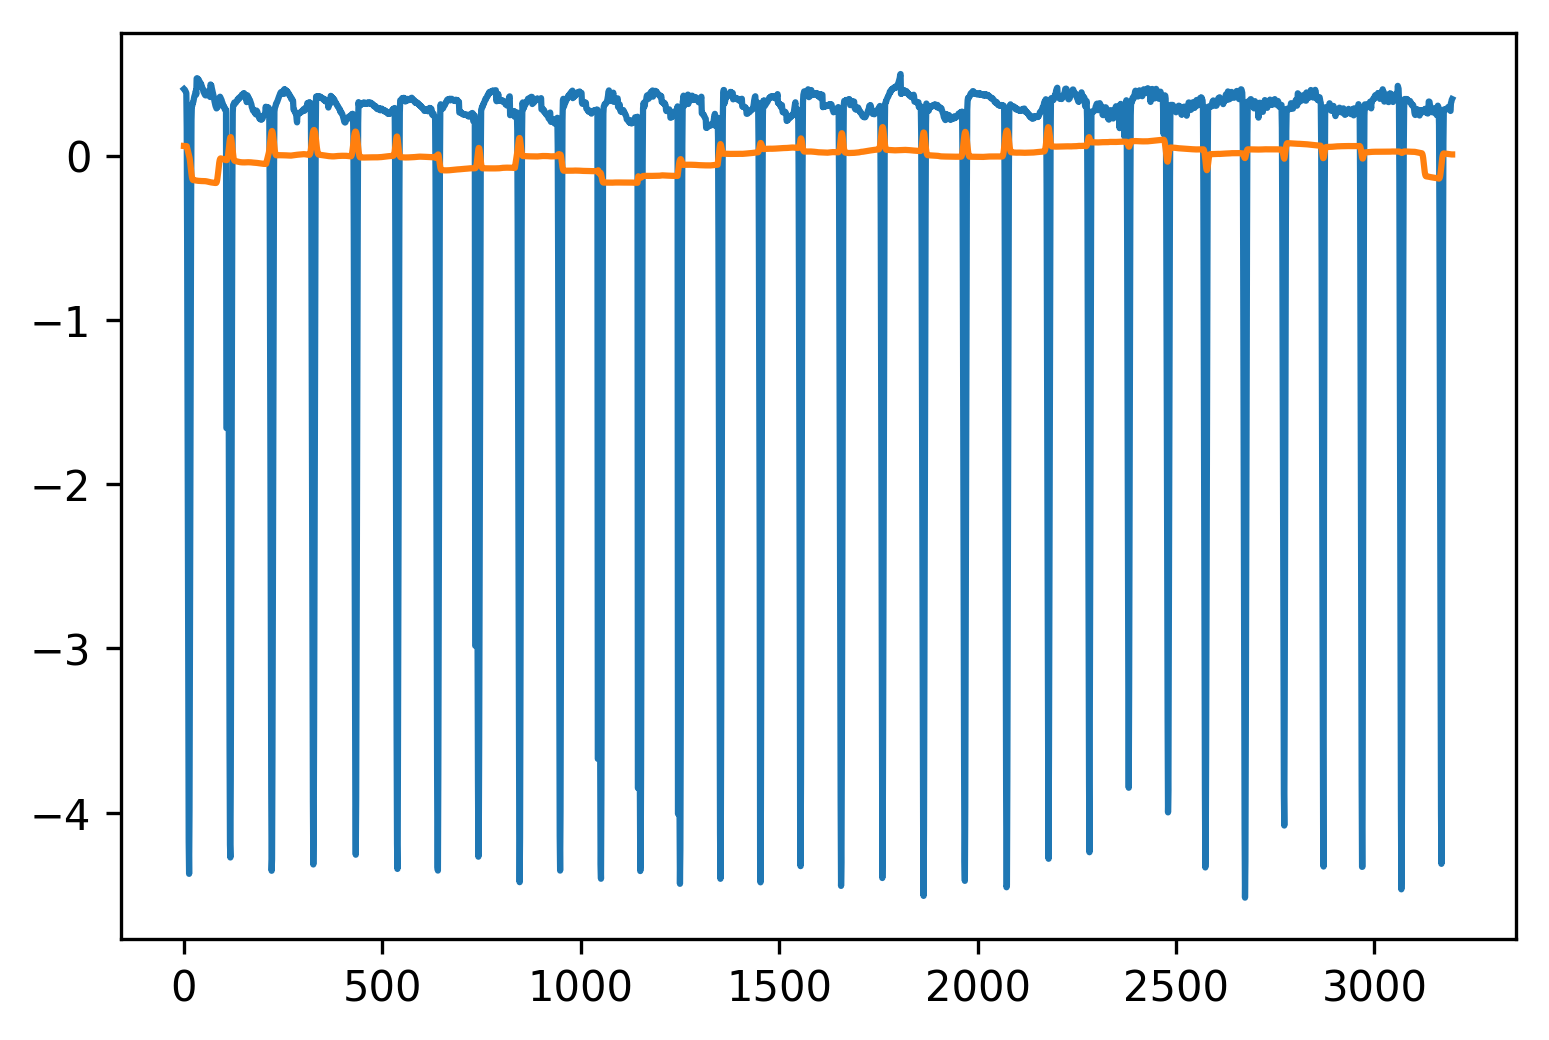

506 0.996858 False


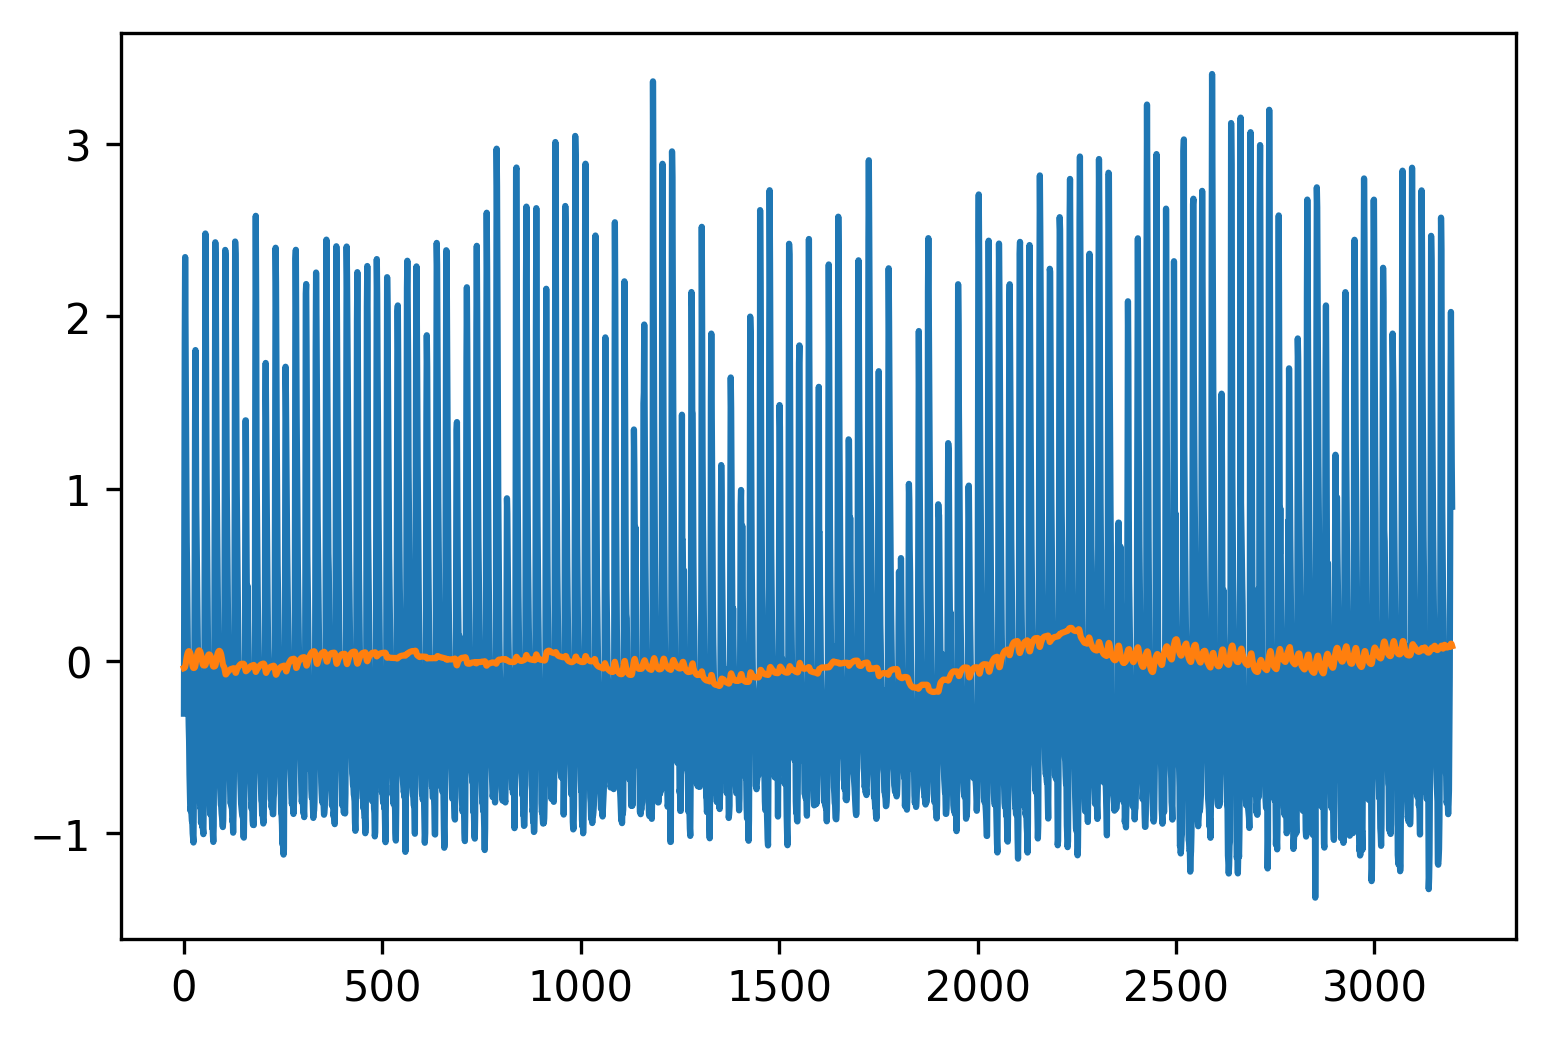

In [27]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i, y_hat[i], y_test.astype('bool').ravel()[i])
        plt.plot(x_test[i])
        plt.show()

It seems NASA missed one planet. I take this opportunity to claim it, and hereby name it Kaggle alpha :)